<a href="https://colab.research.google.com/github/EragonRussia/withBears/blob/main/Aerial_polar_bears.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 7672, done.
remote: Counting objects: 100% (392/392), done.
remote: Compressing objects: 100% (188/188), done.
remote: Total 7672 (delta 244), reused 290 (delta 201), pack-reused 7280
Receiving objects: 100% (7672/7672), 9.05 MiB | 25.26 MiB/s, done.
Resolving deltas: 100% (5262/5262), done.
/content/yolov5
HEAD is now at 886f1c0 DDP after autoanchor reorder (#2421)


In [4]:
!pip install -qr requirements.txt
import torch

from IPython.display import Image, clear_output
from utils.google_utils import gdrive_download

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 645kB 8.4MB/s 
Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [51]:
%cd /content
!curl -L "https://app.roboflow.com/ds/RgqOM1xxz2?key=upuwcmuA2s" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1677      0 --:--:-- --:--:-- --:--:--  1674
100 1318k  100 1318k    0     0  1836k      0 --:--:-- --:--:-- --:--:-- 1836k
Archive:  roboflow.zip
replace README.roboflow.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: README.roboflow.txt     
 extracting: data.yaml               
 extracting: test/images/2016-05-13-10-16-57_0024_1L_JPG.rf.99aa32968404ad762dfcc3673aff5422.jpg  
 extracting: test/images/2016-05-13-11-33-21_0855_2R_JPG.rf.ae7e06fc57fd5a7c4043eac7353f7de9.jpg  
 extracting: test/images/2016-05-18-11-43-50_1486_1L_JPG.rf.97067baddb7b501314e5c49882d4a77f.jpg  
 extracting: test/labels/2016-05-13-10-16-57_0024_1L_JPG.rf.99aa32968404ad762dfcc3673aff5422.txt  
 extracting: test/labels/2016-05-13-11-33-21_0855_2R_JPG.rf.ae7e06fc57fd5a7c4043eac7353f7de9.txt  
 extracting:

In [52]:
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['polar-bear']

In [53]:
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [54]:
%cat /content/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [55]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [56]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}
depth_multiple: 0.33
width_multiple: 0.50

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],
   [-1, 1, Conv, [128, 3, 2]],
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],
   [-1, 3, BottleneckCSP, [512, False]],

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],
   [-1, 3, BottleneckCSP, [256, False]],

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],
   [-1, 3, BottleneckCSP, [512, False]],

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],
   [-1, 3, BottleneckCSP, [1024, False]],

   [[17, 20, 23], 1, Detect, [nc, anchors]],
  ]

In [57]:
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
github: ⚠️ WARNING: code is out of date by 322 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 v4.0-126-g886f1c0 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='./models/custom_yolov5s.yaml', data='../data.yaml', device='', entity=None, epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5s_results4', single_cls=False, sync_bn=False, total_batch_size=16, weights='', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboard with "tensorboard --log

GROUND TRUTH TRAINING DATA:


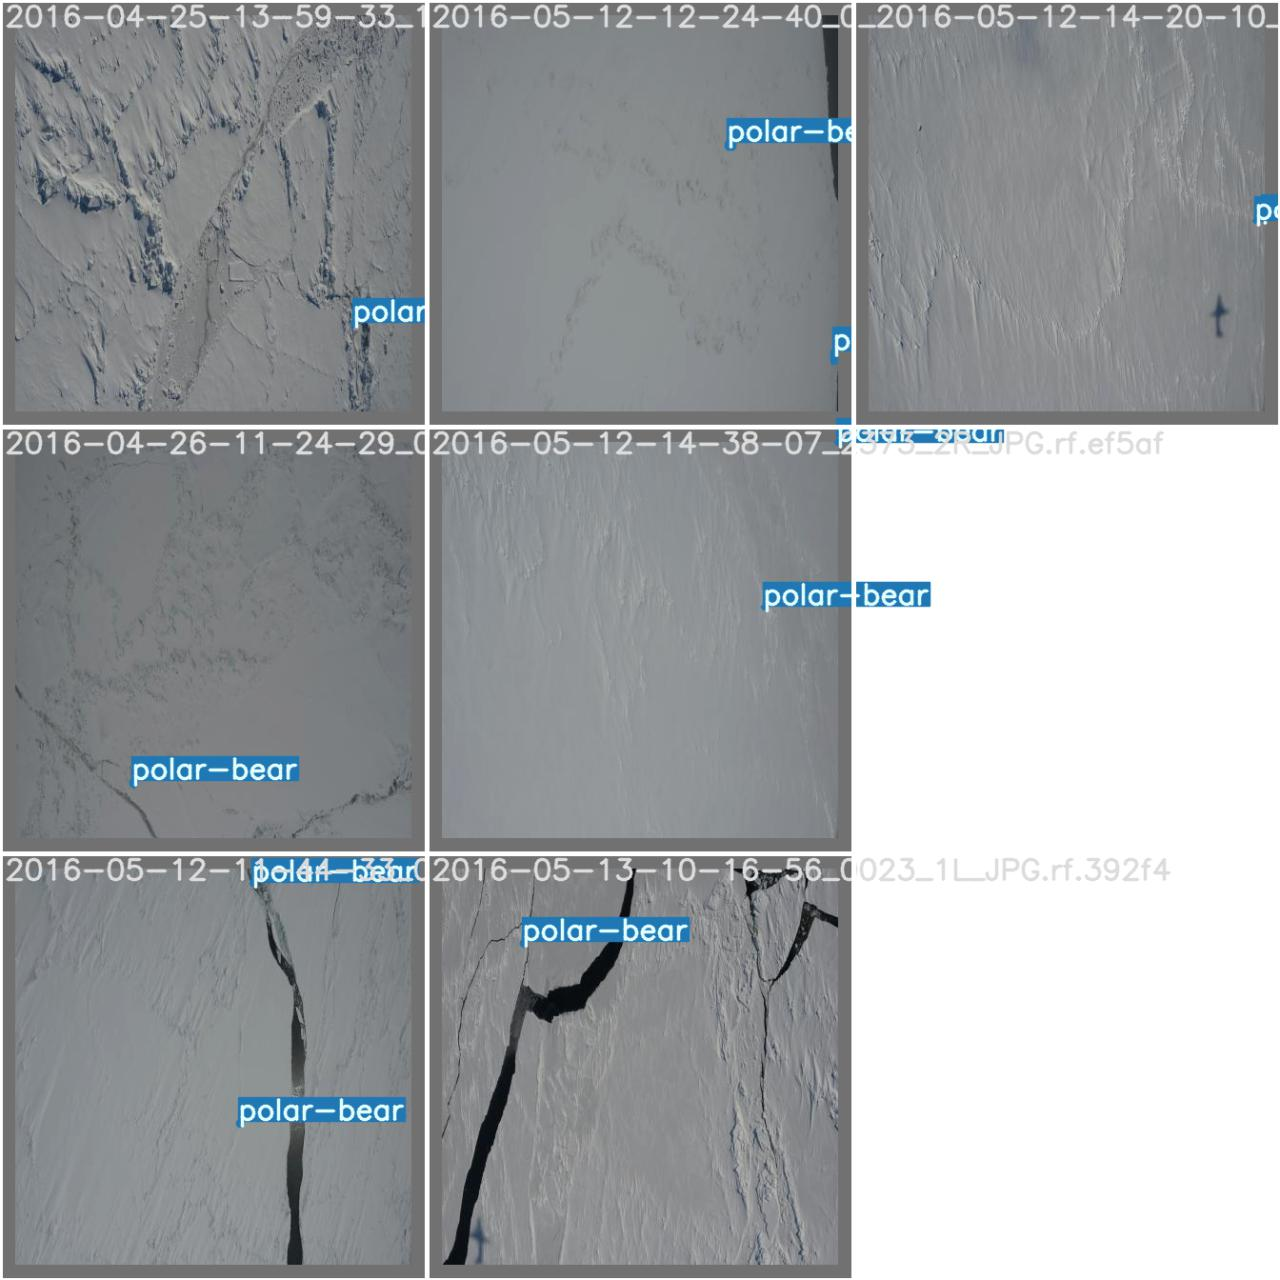

In [59]:
Image(filename='/content/yolov5/runs/train/yolov5s_results4/test_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


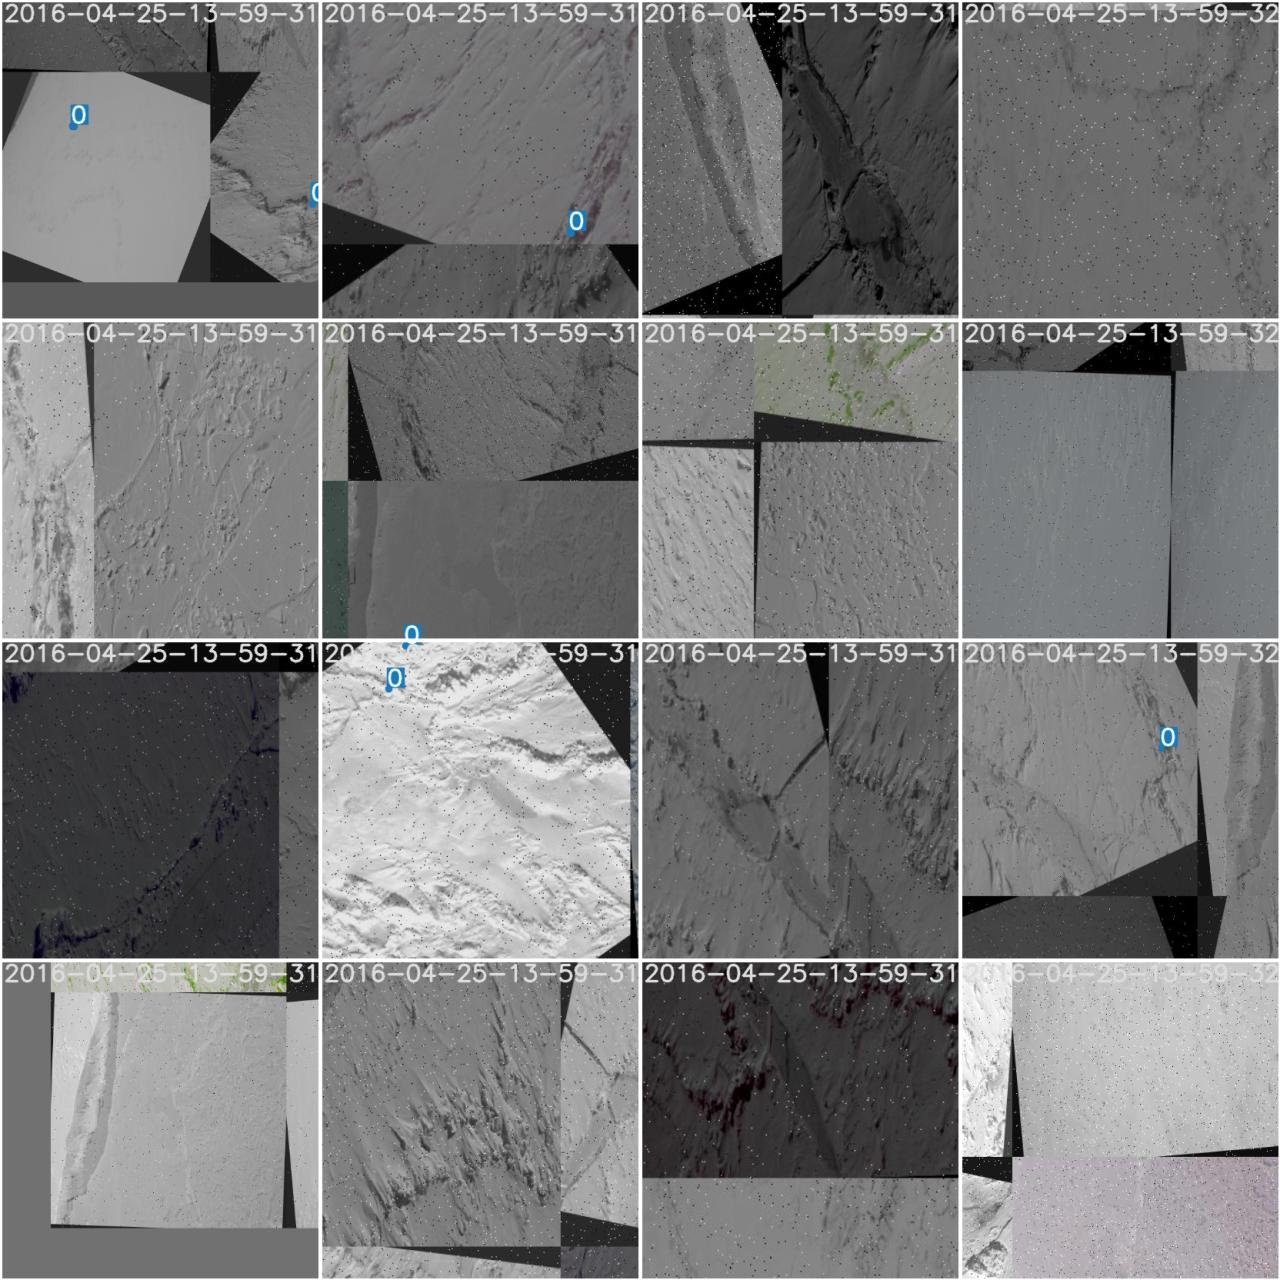

In [61]:
Image(filename='/content/yolov5/runs/train/yolov5s_results4/train_batch0.jpg', width=900)

In [70]:
%ls runs/

detect/  train/


In [71]:
%ls runs/train/yolov5s_results/weights

In [64]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results4/weights/best.pt --img 416 --conf 0.4 --source ../test/images

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='../test/images', update=False, view_img=False, weights=['runs/train/yolov5s_results4/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 232 layers, 7246518 parameters, 0 gradients, 16.8 GFLOPS
image 1/5 /content/yolov5/../test/images/2016-05-13-10-16-57_0024_1L_JPG.rf.99aa32968404ad762dfcc3673aff

In [66]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [67]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [68]:
%cp /content/yolov5/runs/train/yolov5s_results4/weights/best.pt /content/gdrive/My\ Drive